## Goal

* Use various optimization methods to estimate the sources/sinks of CO$_2$ over land
* Investigate the role of prior estimates and observations
* Investigate the impact of transport errors


## Introduction

The optimal land uptake found in Exercise 2 was determined by trial and error, and by judging the difference to the 
observations using the human eye. In data assimilation this "forward modeling" of the problem is very important. It 
gives the researcher a good feeling for the system, and helps build an expectation of the outcome of a more formal optimization 
process. Once the forward modeling yields a satisfactory system, an optimization algorithm can be used to fine-tune 
the solution and find the numerically best values for a set of unknowns.

Often, the best numerical solution is one that best reproduces observations, quantified by for example the root-mean-square-error (RMSE):
    
$ RMSE=\sqrt{\frac{1}{(N-1)}\sum y^{0}-H(x))^2 } $     .........(Equation 1)

In which we use:

$y^{0}$ = Observations [ppm]

$x$ = the unknown scaling factor for the land-sink [-]

$H$ = a linear operator on $x$ that makes it comparable to $y^{0}$: MOGUNTIA

$H(x)$ = MOGUNTIA calculated value of the CO$_2$ mole fraction given $x$ [ppm]

$N$ = number of observations

We often tend to say that the value of the land sink $x$ that is "optimal", is the one that minimizes the RMSE to observations ($y^{0}$) once run through the MOGUNTIA model ($H$). The RMSE is an example of a so-called L2-norm, in which deviations from the observed value are weighted in quadrature. If we had used the absolute difference  $ | y^{0}-H(x) | $, this would have put less emphasis on larger deviations (an L1-norm). 

Defining what the 'optimum' means in the solution of your problem is thus a very important first step. This choice leads to the choice of optimization method, the restrictions on the type of errors you use, and often the numerical methods available to you. In many atmospheric application the basis for your optimization is a so-called cost function, and we often restrict ourselves to an L2-norm:

$ J(x) = (y^{0}-H(x)) R^{-1} (y^{0}-H(x))^{T}  $   .........(Equation 2)

where we have two new symbols, and we refer to y and H(x) now as vectors:

$ J $ = the cost assigned to a proposed solution $x$

$ R $ = the covariance of the model-data mismatch [ppm]$^{2}$

The NxN matrix $R$ represents the uncertainty incurred when comparing each observation to its modeled value, due to for example observational errors, transport model errors, model sampling errors, etc. These errors provide the weight for each measurements in the overall cost calculated. 

<FONT COLOR=red>

# Part 2: Data Assimilation of CO$_2$: Finding the sources and sinks 

<FONT COLOR=black> 

##### Wouter Peters, December 2021

##### version 1.0 

<div class="alert alert-block alert-info">
<b>Tip:</b> 

You can go through this practical at your own pace: 

 1. For a novice user, it is fine to just read the instructions, execute the cells, and try to answer the questions. Sometimes you might need to modify a value in the code and run a cell multiple times. In that case focus on the part of the cell that looks like this:

```python
1| ############### YOUR INPUT BELOW ################
2| 
3| SomeVariable = [1,2,3  <--- You make a change    
4|    
5| ############### YOUR INPUT ENDS ################                      
```                            
 
 2. For a regular user, it might be nice to read and understand the python code in the cells. In that case look at the parts indicated by:
  
```python 
1| ############### PYTHON CODE STARTS BELOW ################    
```

 3. Expert users are challenged to also modify and write code to explore the material further   
</div>

    


<figure>
  <img src=https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-03-17-20-40.png width="500" height="400">
  <figcaption> <i>Figure 3: Many optimization methods use quadratic cost functions, with a minimum defined in the N-dimensions of the problem being solved. Two dimensions we can visualize recognizably still
</i></figcaption>
</figure>

## Exercise 3a: The quadratic cost function


<P><FONT COLOR=darkblue>

In the cell below, you can investigate the two metrics above (RMSE and J) in the runs you did so far. There is also one output file already made for you, which holds the x$_{a}$ from the minimum least squares method. Its value for the global land sink is close to 2.1 as used in simulation `fixedsink.in`. 

---
<div class="alert alert-block alert-warning">
<b>To do</b> 
    
<FONT COLOR=red>

* Inspect the cell, and see if you understand the Python code provided. 

* Print the values of the RMSE and cost function for some of the runs you've done. Can you recognize the "best" simulation from the metrics? 

* How does the metric depend on the set of observations you include in the set? Try to add an "independent" site to the set that makes the cost function go very high. Is there also one that keeps the cost function low?

* How does this metric depend on the model-data mismatch R? Try an alternative one (modify in the cell) and understand its impact. 

</FONT>
</div>    
---

In [7]:
#### PLEASE EXECUTE THIS CELL ONCE UPON STARTUP, IT LOADS A SET OF NEEDED PYTHON LIBRARIES ####


%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpda
import seaborn as sns

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RMSE [ppm] : 4.411954 
J  [-]  : 3594.781555


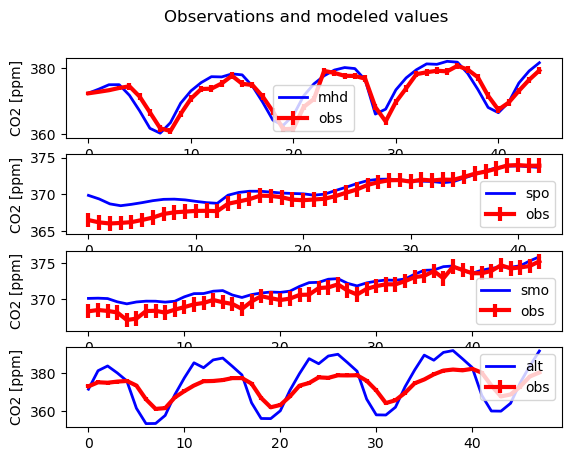

In [8]:
############### YOUR INPUT BELOW ################


############################# Define a set of sites to assess with our metrics: ############################

obsset = ['mhd','spo','smo','alt']
mdm = [0.5,0.5,0.5,0.5] # in ppm

assert len(obsset) == len(mdm),'Please specify as many model-data mismatch values as sites in the obsset'


############################# Get the observations and modeled values for a given experiment ############################

y,Hx,info = mpda.get_concentrations('FOSSIL3',obsset)


############### YOUR INPUT ENDS ################


############################# We define the weight of each observation using the matrix R: ############################

R = mpda.make_R(info,mdm) # 0.5 ppm^2 measurement uncertainty for all observations 

############################ Compute the metrics ############################

RMSE = np.sqrt(((y-Hx)**2).mean())    # make RMSE for this run
J =  np.dot(np.transpose(y-Hx),np.linalg.inv(R)).dot(y-Hx)   # make J for this run

print(f'RMSE [ppm] : {RMSE:f} \nJ  [-]  : {J:f}')

############################# plot the outcomes per site ############################

fig, axs = plt.subplots(len(obsset))
fig.suptitle('Observations and modeled values')

istart=0
for i,site in enumerate(obsset):
    nn=info[site]
    iend=istart+nn
    
    axs[i].plot(np.arange(nn),Hx[istart:iend],lw=2,color='blue',label=site)
    axs[i].errorbar(np.arange(nn),y[istart:iend],yerr=np.sqrt(R.diagonal()[istart:iend]),lw=3,color='red',label='obs')
    axs[i].legend()
    axs[i].set_ylabel('CO2 [ppm]')

    istart+=nn


## Exercise 3b: The minimum least-squares solution

<P><FONT COLOR=darkblue>

With this cost function, we can easily create our first real 'optimal' solution of the scaling factor for the land sink. It is given by the Ordinary Least Squares (OLS) solution used also in simple linear regression:
<P>

$x^{a}=(H^{T} R H)^{-1} H^{T}Ry^{0}$

with the subscript $a$ referring to the "analysis", representing the optimal value of the state $x$ after using all observations $y^{0}$ with each of their weights $R$.
<P>


<figure>
  <img src=https://cdn-images-1.medium.com/max/500/0*gglavDlTUWKn4Loe width=400 height=400 align=center>
  <figcaption> <i>Figure 4: The Ordinary Least Squares fitting of a straight line through your data is done by scientists worldwide. Only few realize that the math behind Python and R functions like "optimize", "lingress", "linfit", "polyfit" etc is just a simple variant of the algebraic solution given in the cell below 
</i></figcaption>
</figure>

    
In the cell below we create this  minimum least-squares solution for the unknown value of EXTRA_LAND, given the model-data mismatch R of the requested observation set. 
<P>

<div class="alert alert-block alert-info">
<b>Note</b> 
   
Note that we do not actually run the full MOGUNTIA model to create it, but instead we have computed H, the matrix operator that exactly reproduces the transport that MOGUNTIA would do for us with an extra SINK of 1 PgC. We were able to do this because MOGUNTIA transport is fully linear (a doubling of emissions exactly doubles all mole fractions), and allows us to use this relation between one parameter (EXTRA_LAND) and all possible CO$_2$ sites. Moreover, we included the initial condition of CO2=369 ppm and only fossil fuels in the `basefunc_base` run, so that we can subtract it from the measurements before optimizing the residuals. 
</div>

---
    
<div class="alert alert-block alert-warning">

<FONT COLOR='RED'>
<b>To do</b> 
   
* Does the solution depend on the value of R (model-data mismatch)? Why (not)?

* And what about the observation set, does it influence x_a? Can you use one site? Which one would you pick?

* Compare the cost function and RMSE to the solution of a run called FIXEDSINK, which used an EXTRA_LAND sink of 2.1 PgC/yr
    </div>
---

MLS solution for x_a : 2.097
RMSE [ppm] : 1.896205 
J  [-]  : 692.984235


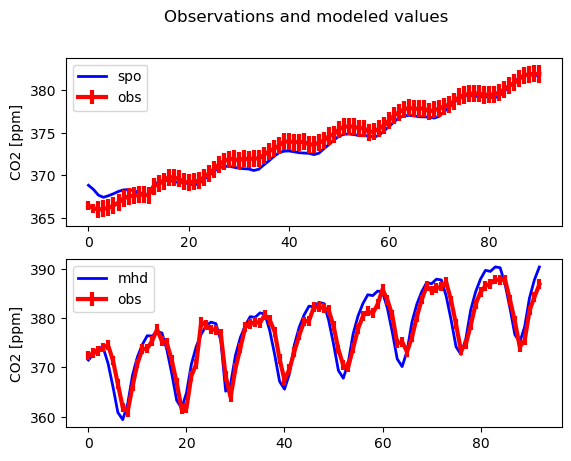

In [13]:
############### YOUR INPUT BELOW ################


############################# Define a set of (>1) sites to use in the optimization: ############################

obsset = ['spo','mhd']
mdm = [0.5,0.5]   # in ppm

assert len(obsset) == len(mdm),'Please specify as many model-data mismatch values as sites in the obsset'

############################# Get H, the observations and modeled values for a given experiment ############################

############### YOUR INPUT ENDS ################

############### PYTHON CODE BELOW ################


H= mpda.get_H(obsset,glob=True)    # Get the linearized MOGUNTIA model matrix H

# Get a run with no extra sinks (but with fossil fuels, ocean and biosphere), 
# and pre-subtract it from the observations (y). 
# Now x_a is the remaining sink, and y [in ppm] is the extra uptake needed

y_full,Hx_b, info = mpda.get_concentrations('basefunc_base',obsset) # Get the run without an extra sink

y = y_full-Hx_b  # presubtract it

############################# We define the weight of each observation using the matrix R: ############################


R = mpda.make_R(info,mdm) # 0.5 ppm^2 measurement uncertainty for all observations 


################### MLS solution algebra given below ###################

w1=np.dot(np.transpose(H),np.dot(R,H))  # bracket term
w2=1./w1          # inverse bracket
w3=np.dot(w2,np.transpose(H)) # times X^T
x_a=np.dot(w3,np.dot(R,np.transpose(y)))  # times y

############################################################################

print (f'MLS solution for x_a : {x_a:4.3f}')

############################ Compute the metrics ############################

Hx = H*x_a
RMSE = np.sqrt(((y-Hx)**2).mean())    # make RMSE for this run
J =  np.dot(np.transpose(y-Hx),np.linalg.inv(R)).dot(y-Hx)   # make J for this run

print(f'RMSE [ppm] : {RMSE:f} \nJ  [-]  : {J:f}')

############################# plot the outcomes per site ############################

nplots=max([len(obsset),2])
fig, axs = plt.subplots(nplots)
fig.suptitle('Observations and modeled values')

istart=0
for i,site in enumerate(obsset):
    
    nn=info[site]
    iend=istart+nn
    
    axs[i].plot(np.arange(nn),(Hx_b+Hx)[istart:iend],lw=2,color='blue',label=site)
    axs[i].errorbar(np.arange(nn),(Hx_b+y)[istart:iend],yerr=np.sqrt(R.diagonal()[istart:iend]),lw=3,color='red',label='obs')
    axs[i].legend()
    axs[i].set_ylabel('CO2 [ppm]')

    istart+=nn
 

## Exercise 3c: Extra challenge

---
<div class="alert alert-block alert-warning">
<b>To do</b> 
   
<FONT COLOR=red>
    
* Write some code to plot the shape of the cost function for various values of EXTRA_LAND. Use the cell below as starting point

* Find the minimum value calculated, compare it to the MLS solution. Can you make them equal?

* Hint: copy the cost function lines from the cells above
    </div>
---


In [4]:
Jvals=[]

solutions = np.arange(-1,5,0.5) # try solutions from -1 to +5 in steps of 0.5 PgC/yr 

for x in solutions:
    Hx = H*x    # create mole fractions in [ppm] for solution x

# You code it from here...
    
    

<details><summary>CLICK TO SEE THE SOLUTION TO THE EXTRA EXERCISE</summary>
<p>

```python

Jvals=[]

solutions = np.arange(-1,5,0.5) # try solutions from -1 to +5 in steps of 0.5 PgC/yr

# You code it from here...

for x in solutions:
    Hx = H*x    # create mole fractions in [ppm] for solution x
    J =  np.dot(np.transpose(y-Hx),np.linalg.inv(R)).dot(y-Hx)   # make J for this run
    Jvals.append(J)
    
Jvals=np.array(Jvals)
best = Jvals.argmin()
print(f'x_a : {solutions[best]:4.3f}\nJ   : {Jvals[best]:4.3f}')

plt.plot(solutions,Jvals)  
    
```

</p>
</details>

## Exercise 3d: Adding a prior term to the cost function



<P><FONT COLOR=darkblue>

The cost function $J$ above is quite simple, and does not allow for other information than the observations to play a role in the final solution. However, quite often we start data assimilation with a 'first-guess' or other type of a-priori information on the state of a system. And just like with observations, we want our final solution to stay close to such information too.

Including a-priori information in the cost function is an essential component of data assimilation, and sets it aside from simple curve-fitting or linear regression. This is because the first-guess state of a system can be predicted by information from a previous moment in time, or from expert information. Such information can be added to the cost function:

$J(x)=(y^{0}-H(x))R^{-1}(y^{0}-H(x))^{T}+(x - x^{p})P^{-1}(x - x^{p})^{T} $  

where:

$x^{p} $ = prior information on the state (obtained from expert knowledge or a model of the state)

$P$ = covariance matrix representing the full error structure of the prior state

The optimal solution (minimum cost J) thus depends on the relative uncertainties assumed in the model-data comparison (R) and in the uncertainties in the prior state (P). If one becomes very small (low errors), deviations will incur high costs.

In the cell below, we once again calculate the cost function for various values of EXTRA_LAND but now with a prior term added. 
    
    
<div class="alert alert-block alert-warning">
<b>To do</b> 
   
<FONT COLOR=red>

---

* Read and understand the cell below, then execute it. Which term in J is smaller? What does it mean?
    
* Change the values of P, and/or R and execute the cell again. What is needed to make J1 ~ J2?    
    
* Can you think of a way to make the solution (minimum cost) stick to the prior value of 1.0? Try it.
    </div>
---

In [ ]:
%matplotlib inline
############### YOUR INPUT BELOW ################

x_p = np.array([1.0])  # We think the solution should stay close to 1.0 PgC/yr, so we make this the prior
P = np.array([0.16])  # We give it a reasonable error of 40%

############### YOUR INPUT ENDS ################

############### PYTHON CODE  BELOW ################

Jvals=[]


R =mpda.make_R(info,mdm)

solutions = np.arange(-1,5,0.1) # try solutions from -1 to +5 in steps of 0.5 PgC/yr
for x in solutions:
    Hx = H*x    # create mole fractions in [ppm] for solution x
    J1 =  np.dot(np.transpose(y-Hx),np.linalg.inv(R)).dot(y-Hx)   # make J for this run
    J2 = np.dot(np.transpose(x-x_p),1./P[0]).dot(x-x_p)
    J = J1 + J2
    #print(x,J1,J2,J)
    Jvals.append([J1,J2,J])
    
J1=np.array(Jvals)[:,0]
J2=np.array(Jvals)[:,1]
J=np.array(Jvals)[:,2]
best = J.argmin()
print(f'x_p : {x_p[0]:4.3f}\nx_a : {solutions[best]:4.3f}\nJ   : {J[best]:4.3f}')

plt.plot(solutions,J1,label='J1')
plt.plot(solutions,J2,label='J2')
plt.plot(solutions,J,label='J')
plt.plot([solutions[best],solutions[best]],[-1.0*J.max()/8.0,J.max()/2.0],
                     color='red',lw=2,label=f'minimum J ({solutions[best]:4.3f})')
plt.legend()
    

Although this seemed like an easy method to solve for the optimal parameter x_a, we cannot easily calculate the solution of the cost function minimum by trial and error when we have a more complex model, or more than a few parameters to consider. This is the situation we will look at next, and introduce the (ensemble) Kalman Filter 

### Exercise 4: A more complex solution to a more complex problem: The ensemble Kalman Filter

<P><FONT COLOR=darkblue>

We will explore this cost function and the solution with an a-priori estimate further. To make this a bit more interesting we do this directly for a set of three unknowns simultaneously:

<P>
    
LAND_SINK_NH : the land sink on the Northern Hemisphere (>30N)

LAND_SINK_TR : the land sink in the Tropics (30S-30N)

LAND_SINK_SH : the land sink on the Southern Hemisphere (<30S)

<P> Which makes our statevector $x$ to estimate:

x = (LAND\_SINK\_NH, LAND\_SINK\_TR, LAND\_SINK\_SH) 

The optimal value is now no longer the simple MLS-equation given above. Instead it has to be calculated by determining the derivative of the cost function and then:

- using it to (iteratively) find the minimum, as is done in variational techniques
- or solving for x where the derivative of J equals zero

The latter solution is given by the famous Kalman Filter equations:

  $x^{a}=x^{p}+K(y^{0}-H(x))$  
                                                               
  with $K=PH^{T}/(HPH^{T}+R)$

  $P^{a}=(I-KH)P^p$

In the rest of this practical we will work with this solution. Moreover, we will pretend that our problem is very large in vector x, y, and thus in R and P. And also that the operator H (the transport of unknowns x to mole fractions at the sites) is non-linear.  That requires a so-called ensemble Kalman filter, which we will explore next 


<div class="alert alert-block alert-info">
<b>Note 1</b> 
   
Note that the assumptions are really not true: our dimensions are O(100) for y and 3 for x, and MOGUNTIA transport is fully linear (a doubling of emissions exactly doubles all mole fractions). Moreover, we reduce the number of observations strongly using a "data thinning factor" to make the problem a bit more challenging (i.e, not over-constrained)
    </div>

<div class="alert alert-block alert-info">
<b>Note 2</b> 
   
The total EXTRA_LAND sink of 1 PgC/yr is not equally distributed over the NH, TR, and SH region. To find back the total global flux resulting from the three parameters, x$_a$ has to be multiplied with [-0.52, -0.45 , -0.03] PgC/region/year.
    
</div>
  
    
<div class="alert alert-block alert-success">
<b>What's next?</b> 
                                                                  
From here on you can continue to **Exercise 4** where we explore the ENKF solution, and it's sensitivity to the choices of the user. For those with an appetite to understand the algorithm in more depth, you can follow the step-wise solution of the Ensemble Kalman Filter by moving more quickly to **Exercise 5**.
    </div>                                                               
---                                                               

## Exercise 4a: Inspecting the three parameter solution

<P><FONT COLOR=darkblue>

We are going to solve the system with three parameters using the Ensemble Kalman Filter algorithm. 
    
<P>
    
In the EnKF, we use the Kalman equations to find the optimum state x$_a$ and its uncertainty P_$a$, but instead of using the matrices P, H, K, and algebra like we saw in the lecture, the EnKF uses a different approach: it makes an approximation of the covariance P, by using a random ensemble of possible state vectors, with the `'` symbol denoting the difference of each from the mean x $_p$: 
    
$[x1',x2',x3',...,xN']$ 
    
<P>
The members of this ensemble are each put into the Observation Operator (${\cal H}$ -> MOGUNTIA) to get an ensemble of model calculated mole fractions, each deviating slightly from the mean ${\cal H}$(x$_p$):
    
$[{\cal H}(x1'),{\cal H}(x2'),{\cal H}(x3'),...,{\cal H}(xN')]$   
    
<P> With these vectors all calculated quite efficiently in parallel on a large computer. Moreover, they are created with the actual Observation Operator ${\cal H}$, and not with a linearized version of it (H), which allows slightly non-linear behavior of the system. The Kalman filter equations can be solved easily (demonstrated in Exercise 5). Its accuracy depends mostly on `N`, the size of the ensemble used.
    
To make things a little easier, we have coded up the algorithm already, it just needs the user input to work. In the cell below, please specify:
    
    1. An identifier for the experiment, so we can create a MOGUNTIA input file with the optimized parameters
    2. The set of observations to use in determining the 3 parameters, and their uncertainty (R)
    3. An a-priori estimate of the three values (x_p)
    4. An estimate of their uncertainty (P)
    5. A size of the ensemble to use (NMEMBERS, please restrict to <30)
    6. Optionally, you can select a data thinning factor (`dtf`, selecting only every Nth observation from the set to estimate x

<div class="alert alert-block alert-info">
<b>Note</b> 
    
* When the optimization is done, an input file to run MOGUNTIA will be written to the disk 
* It will have the name as specified below in the variable `name`, which you can change
* You can directly use it with the run/plot interface that you also used in exercise 1 and 2 (cell below)
* When modifying the covariance structure, it can happen that a non positive-definite matrix P is created, which will cause the "Cholesky decomposition" to fail in the next cell. If so, please modify the P-matrix.    
    </div>    
---
<div class="alert alert-block alert-warning">
<b>To do</b> 
   
<P><FONT COLOR=red>

* Create the values 1-6 in the cell below and run the EnKF. 
* Inspect the x$_a$ and P results printed, and look at the posterior covariance matrix P.
* How does the solution with three parameters compare to the one with 1 parameter? Try to explain the outcome
    
    </div>  
---


propagating member_000 (mean)
propagating member_001
propagating member_002
propagating member_003
propagating member_004
propagating member_005
propagating member_006
propagating member_007
propagating member_008
propagating member_009
propagating member_010
Optimized statevector:  [ 3.44703131  0.94371619 -0.60531922]
Optimized cost J(x): 998.765
Extra land sink total [PgC/yr]: -2.199


<AxesSubplot: >

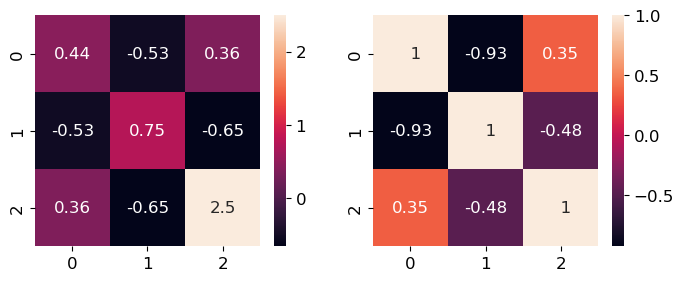

In [23]:
############### YOUR INPUT BELOW ################

### Element 1: Please provide a name ####

name = 'enkf_R2_P2_N10_spo_mhd'

### Element 2: Please provide the model-data mismatch to use for each site ####

obsset = [ 'spo','mhd']  
mdm = [ 0.5, 0.5]        # ppm

assert len(obsset) == len(mdm),'Please specify as many model-data mismatch values as sites in the obsset'


### Element 3: Please provide an a-priori estimate for x ####

x_p = np.array([0.0,0.0,0.0]) # For NH, Tropics and SH

### Element 4: Please provide the covariance structure for x ( in P) ####

P = np.array([
    # 1    2    3
    [2.0**2, 0.0, 0.0], # 1: NH 
    [0.0, 2.0**2, 0.0], # 2: Tropics
    [0.0, 0.0, 2.0**2]  # 3: SH
])
# P = np.array([
#     # 1    2    3
#     [2.0**2, 0. , 0.0], # 1: NH 
#     [0. , 2.0**2, 0.0], # 2: Tropics
#     [0.0, 0.0, 2.0**2]  # 3: SH
# ])


### Element 5: Please provide the number of members to use (<30) ####

NMEMBERS = 10

### Element 6: Please provide the data thinning factor (dtf) to sub-select the observations time series

dtf = 20  # Take every n-th obervation available from the obsset into the algorithm

assert dtf in range(1,90),'Data thinning factor out of range 1,...90'

############### YOUR INPUT ENDS ################


########################### Code below calculates the solution ################################################

flux_per_region = np.array([-0.52, -0.45 , -0.03])   # PgC/yr, this is from the co2biosink file

x_a,P_a, J=mpda.enkf(x_p, P, obsset, mdm, NMEMBERS,dtf=dtf)
mpda.write_member(x_a,name)   # this creates a MOGUNTIA input file for you to use, with optimized values

extra_flux = (flux_per_region*x_a)
################################################################################################################

print('Optimized statevector: ',x_a)
print(f'Optimized cost J(x): {J:4.3f}')
print(f'Extra land sink total [PgC/yr]: {extra_flux.sum():4.3f}')

fig,axs= plt.subplots(1,2,figsize=(8,3))
sns.heatmap(P_a, annot=True, fmt='3.2g',ax=axs[0])
sns.heatmap(mpda.cov2corr(P_a), annot=True, fmt='3.2g',ax=axs[1])


---
<div class="alert alert-block alert-warning">
<b>To do</b> 
   
<P><FONT COLOR=red>

* Run the optimized solution through MOGUNTIA, and inspect it below. How does it's fit compare to that of your run from exercise 2 with the 1 parameter that you manually tuned?    
    
* Does the model do well (better?) at independent sites, i.e., those that were not used to find the parameters? Why?    
    </div>    
---


In [21]:
# Use this cell to run the optimized parameters forward and inspect the results

import plot_moguntia as pm
moguntia = pm.plot_moguntia()

Box(children=(Box(children=(Dropdown(description='Inputfile', options=('enkf_R2_P2_N10_spo_mhd.in', 'fixedsink…

interactive(children=(ToggleButton(value=False, description='Make Plots'), Output()), _dom_classes=('widget-in…

---
<div class="alert alert-block alert-warning">
<b>To do</b> 
   
<P><FONT COLOR=red>
    
* Go back to the cells aboven and run the system again, try to answer the following questions:
    
    * What happens when you use a different (set of) sites. Do you notice differences in the parameters?
    * Try to modify the balance of the cost function, by putting more or less emphasis on the observations, or on one of the parameters [x1,x2,x3] through P and model-data mismatch (going into matrix R).
    * Does the result change with the value of NMEMBERS?
    * Modify the number "dtf", to use more (dtf small) or less (dtf large) observations in the optimization. What do you see in the solution?      

HINT: You can use the cell below to calculate the RMSE of various runs. Which sites improve in the 3-parameters fit? 
    
</div>    
---


RMSE [ppm] : 1.629309


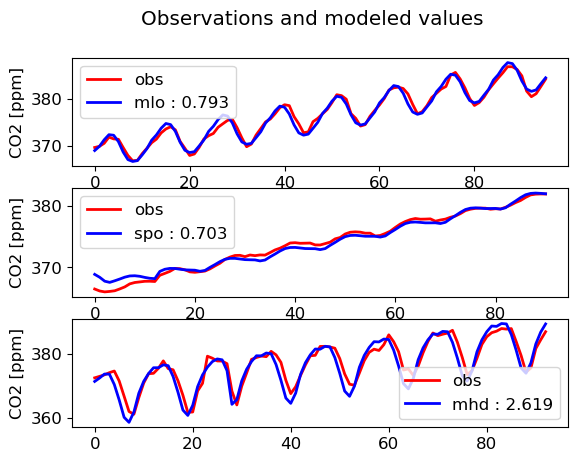

In [27]:
############### YOUR INPUT BELOW ################

# Use this cell to inspect the match to observations, either from your prior or posterior run (or another)

obsset=['mlo','spo','mhd']

runname='MEMBER_000'  # this is the prior run
runname = 'enkf_R2_P2_N10_spo_mhd' # or from the previous cells

############### YOUR INPUT ENDS ################

############### PYTHON CODE BELOW ################


y,Hx,info = mpda.get_concentrations(runname,obsset) 

RMSE = np.sqrt(((y-Hx)**2).mean())    # make RMSE for this run

print(f'RMSE [ppm] : {RMSE:f}')

############################# plot the outcomes per site ############################

plts=max(len(obsset),2)

fig, axs = plt.subplots(plts)
fig.suptitle('Observations and modeled values')

istart=0
for i,site in enumerate(obsset):
    
    nn=info[site]
    iend=istart+nn

    RMSE = np.sqrt(((y[istart:iend]-Hx[istart:iend])**2).mean())    # make RMSE for this site
    
    axs[i].plot(np.arange(nn),y[istart:iend],lw=2,color='red',label='obs')
    axs[i].plot(np.arange(nn),Hx[istart:iend],lw=2,color='blue',label=f'{site:s} : {RMSE:4.3f}')
    axs[i].legend()
    axs[i].set_ylabel('CO2 [ppm]')

    istart+=nn



In [10]:
# Copy other EnKF runs here and execute the cell

## Exercise 4b: The influence of the transport model

During the lecture yesterday, we discussed that one of the largest sensitivities in calculating the sources and sinks is in the transport model (H). To get some feeling for this, we will repeat some of the calculations above but now with an important change to the MOGUNTIA model.

We will therefore use the MOGUNTIA option 'CONVECTION OFF' to run the model again, but now without the vertical redistribution of tracer mass by convection in cloud systems. This is an important component of vertical transport, and without it the model will keep much more tracer mass near the surface.

<div class="alert alert-block alert-warning">
<FONT COLOR='red'>    
<b>To do</b> 
* Open the file `inputtemplate.in`, which is the template for the runs we do for each of the ensemble members, and the mean. Add a line to the code to turn off the convective transport:
    
* Run the Ensemble Kalman Filter again, so that the "no convection solution". HINT: make sure to give the experiment a different `name` in the cell, so you can look at both runs afterwards
    
* Make an expectation (hypothesis) of the result you will see. Then inspect the output, both for x$_a$, P, and the simulated mole fractions    
    
</div>    


In [11]:
# Copy the contents of the EnKF run cell, modify it, and execute the cell

---

## Exercise 5 (extra): Following the step-by-step solution of the EnKF
 
 In the next exercises you will inspect the different steps that complete the EnKF algorithm. It ends with an actual algebraic solution for x_a and P_a, very similar to what you just completed in **Exercise 4**. But with the ensemble created custom for you, and by you, you have more control over the solution and can more easily vary the inputs.
 
 
<div class="alert alert-block alert-info">
<b>Note</b>

The Notebook cells below no longer are separated into input and code, you can read, change, and code as you wish from here on
    
</div>    

 ### Step 5.1: Creating an ensemble to represent our statevector x, and its uncertainty P

<P><FONT COLOR=darkblue>


The solution for $x_a$ and P$_a$ above will be found by using an ensemble of statevectors, propagating them through MOGUNTIA, and then using the output to construct the Kalman Gain matrix (K). The equations for this are described in the paper by [Peters et al., (2005)](https://doi.org/10.1029/2005JD006157) who reproduced them from [Whitaker & Hamill, (2002)](https://doi.org/10.1175/1520-0493(2002)130<1913:EDAWPO>2.0.CO;2).

The first order of business is to *approximate* the structure of the unknowns in our problem with an ensemble. This ensemble should have a mean that is close to the prior statevector, and a covariance structure that resembles closely the one we want to prescribe. Since we have assumed Gaussian errors in the derivation of the Kalman filter equations, we create these member using random normally drawn numbers.
 
In the cell below, you will see the basic settings for our Ensemble Kalman Filter problem with 3 unknowns. It starts from a prior estimate of the statevector of 0.0 (no extra uptake), and we give an uncertainty of ±2.0 on each parameter.

Importantly, we first assume our errors on $x$ to be independent, so P is a diagonal [3x3] matrix. 
<figure>
  <img src=https://i.stack.imgur.com/qudG3.png>
  <figcaption> <i>Figure 5: An example of a covariance matrix for three variables, and the corresponding correlations between each of them
</i></figcaption>
</figure>
    
    
---
<div class="alert alert-block alert-warning">
<b>To do</b> 
    
<P><FONT COLOR=red>

    
Go ahead and inspect the matrix in the output from this cell. 
    
</div>
---


<AxesSubplot: >

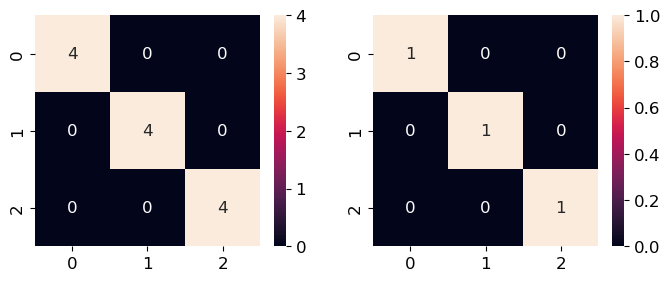

In [28]:
# Create covariance matrix P:

%matplotlib inline

P = [
    # 1    2    3
    [2.0**2, 0.0, 0.0], # 1: NH 
    [0.0, 2.0**2, 0.0], # 2: Tropics
    [0.0, 0.0, 2.0**2]  # 3: SH
]

x_p = np.array([0.0,0.0,0.0]) # For NH, Tropics and SH

P=np.array(P)

fig,axs= plt.subplots(1,2,figsize=(8,3))
sns.heatmap(P, annot=True, fmt='g',ax=axs[0])
sns.heatmap(mpda.cov2corr(P), annot=True, fmt='g',ax=axs[1])

 ### Step 5.1: (continued)


<P><FONT COLOR=darkblue>

    
Next, we draw an ensemble of NMEMBERS size, in which each vector X' = [x1,x2,x3] contains three random values. If we average all values for x1', we get 0.0. If we take the standard deviation of all x1', we get the sqrt(P[0,0]): the uncertainty of x1.

How well this works depends of course on the size of the ensemble. The more members, the better the random normal draw of ensemble members will be.

---
<div class="alert alert-block alert-warning">
<b>To do</b> 
    
<P><FONT COLOR=red>

    
* Inspect the structure of the ensemble as a function of NMEMBERS. Comment on the variances, and covariances in P
    </div>    
---    

[2.26543043 1.56613897 2.10471447]


<AxesSubplot: >

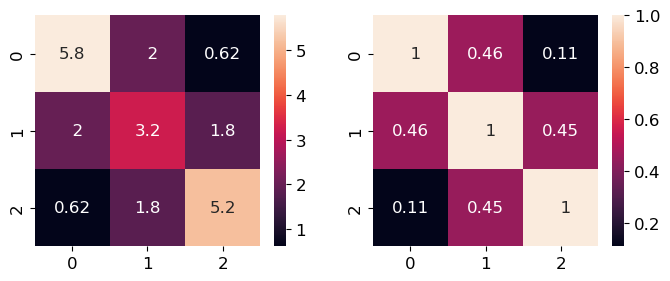

In [29]:
# The number of ensemble members determines how well we can 
# approximate the true structure of the covariances provided by matrix P.
# More members means a closer resemblance, and less 'noise' in the solution

%matplotlib inline

NMEMBERS = 10

# Create members by drawing random vectors of length [3] that follow the structure of P:

X_prime = mpda.draw_members(P, N = NMEMBERS)

print(X_prime.std(axis=1))

# Reconstruct a noisy covariance matrix from these random vectors

P_b = np.dot(X_prime, X_prime.T) / (NMEMBERS-1) # Eq 7

fig,axs= plt.subplots(1,2,figsize=(8,3))
sns.heatmap(P_b, annot=True, fmt='3.2g',ax=axs[0])
sns.heatmap(mpda.cov2corr(P_b), annot=True, fmt='3.2g',ax=axs[1])


<P><FONT COLOR=darkblue>

We can also inspect the individual ensemble members (100x [x1,x2,x3]), by plotting their histogram, and cross-correlations.

<div class="alert alert-block alert-warning">
<b>To do</b>     
<P><FONT COLOR=red>

---

* Try to understand the figure plotted, and the meaning of the scatter plot and histogram    
* How many members do you find sufficient to have a nice Gaussian distribution of each parameter?
    
---

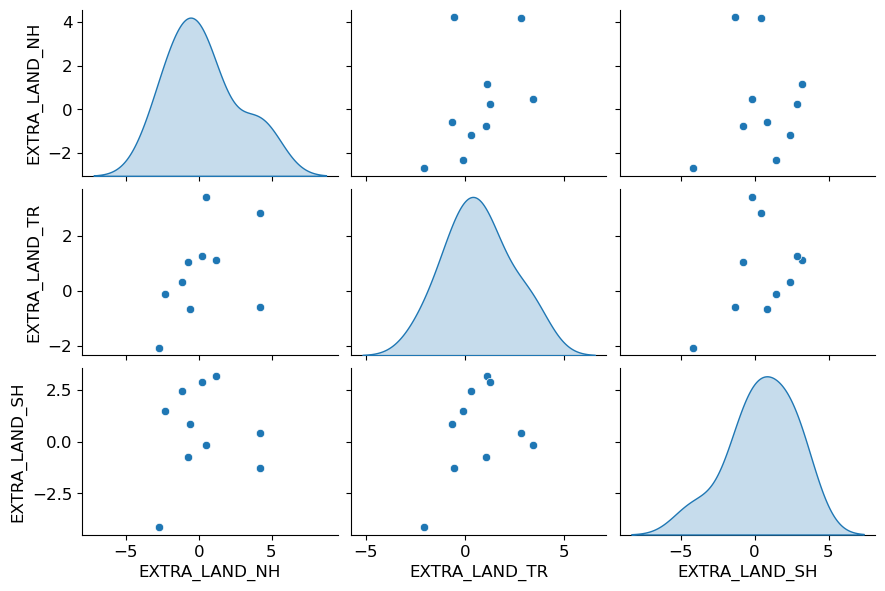

In [30]:
# Plot the individual statevectors as histogram, and scatterplots, visualizing their covariance structure (=P)

data = pd.DataFrame(X_prime.transpose(),columns=['EXTRA_LAND_NH','EXTRA_LAND_TR','EXTRA_LAND_SH'])
pp=sns.pairplot(data,diag_kind='kde',height=2,aspect=1.5)


 ### Step 5.2: Propagating the ensemble through MOGUNTIA: H(x)

<P><FONT COLOR=darkblue>

When you are happy with the ensemble you created, it is time to propagate it through the transport model MOGUNTIA. so that we can make a model sample HX' for each statevector deviation X'

---
<div class="alert alert-block alert-warning">
<b>To do</b> 
<P><FONT COLOR=red>

* Execute the cell below to run each ensemble member with MOGUNTIA. Note that each simulation takes 3-4 seconds, so the total is NMEMBERS*8 seconds. Are you still happy now with your ensemble size?  
    </div>    
---    
    

In [15]:
if mpda.propagate_ensemble(x_p,X_prime):
    print('Succeeded')

propagating member_000 (mean)
propagating member_001
propagating member_002
propagating member_003
propagating member_004
propagating member_005
propagating member_006
propagating member_007
propagating member_008
propagating member_009
propagating member_010
Succeeded


In [16]:
############################# Define a set of (>1) sites to sample data from: ############################

#NOTE: since we already propagated the ensemble members, we can repeat the steps from here to generate a
#NOTE: a solution with a different obsset, or different values of model-data mismatch without rerunning MOGUNTIA :)

################################


obsset = ['mhd','alt','spo','rpb']

mdm=[2.0,2.0,2.0,2.0]  # ppm, for each site

assert len(obsset) == len(mdm),'Please specify as many model-data mismatch values as sites in the obsset'

# We first read in the mean (member 0)

y0, Hx_p, info = mpda.get_concentrations(f'MEMBER_000', obsset)

# And then we do the same for the ensemble members, adding them to the array HX'
# Note that we subtract the mean (member 0) as this was added also before we propagated each member

HX_prime = []

for n in range(1,NMEMBERS+1): 
    
    y, Hx, info = mpda.get_concentrations(f'MEMBER_{n:03}', obsset)
    HX_prime.append(Hx-Hx_p)

HX_prime=np.array(HX_prime)

 ### Step 5.2: (continued)

<P><FONT COLOR=darkblue>

<P>We now have created and read an ensemble of MOGUNTIA simulated mole fractions, each associated with either the mean, or one ensemble member. Let's inspect this array a bit further. We are going to look at one moment in time specifically (month=13) for two sites: MHD and SPO.   

    
<P> We will look at the spread of mole fractions, as well as the spread of values in parameters 1 and 3 (EXTRA_LAND_NH, EXTRA_LAND_SH). Specifically, we will look at the correlations across the ensemble for the two observed locations, as well as for the parameters and observations.     
    
---
<div class="alert alert-block alert-warning">
<b>To do</b> 
<P><FONT COLOR=red>

* Create the plot in the cell below. What does the spread for the observations represent?
* Is the ensemble of mole fractions across the two sites correlated? Why (not)?
* Is the ensemble of the two parameters correlated? Why (not)?
* And what about the correlations between the mole fractions (HX_prime) and parameters (X_prime)? Which correlations are highest? Was that expected?   
* Finally, switch the observation set to use Mace Head (mhd) and Alert (alt). What do you expect? What do you see?    
    </div>    
---    
    

In [17]:
data=pd.DataFrame()

ii=12
for site in info.keys()[0:2]:
   
    data[site] = HX_prime[:,ii]
    ii += info[site]
    
data['EXTRA_LAND_NH'] = X_prime[0,:]       
data['EXTRA_LAND_SH'] = X_prime[2,:]       

pp=sns.pairplot(data, kind='kde',height=2,aspect=1.5)

TypeError: 'odict_keys' object is not subscriptable

 ### Step 5.3: Optimizing three parameters with the ENKF solution

<P><FONT COLOR=darkblue>

The correlation structures above form the basis of the ensemble Kalman filter: high correlations between an ensemble of applied statevectors (X_prime) and simulated mole fractions (HX_prime) such as for EXTRA_LAND_NH and site "Mace Head" denote that this site is sensitive to this parameter. In fact, the matrices X_prime and HX_prime are used to create the Kalman gain matrix (K) which has units of [parameter]/[ppm].

    
<P>To complete the solution, we therefore provide all the information to the ENKF algebraic solution, which returns the X_a and P_a.    
    
---

<P><FONT COLOR=red>
<div class="alert alert-block alert-warning">
<b>To do</b> 
    
* Run the ENKF in the cell below, and inspect the optimized parameter values. Is the outcome what you expected? Why (not)?
    
* Also inspect the optimized covariance and correlation matrix. What do you notice?
    </div>    
---    
    

In [ ]:
    """ ensemble Kalman Filter solution for a system with more obs than parameters, serial algorithm
    R: Uncertainty on observations
    y: observations
    wb: prior scaling factor estimate
    Hx: Simulated mole fractions
    Pb: prior uncertainty estimate on scaling factors
    X_prime: Deviations from mean"""

    import copy 
    okdebug = False
    
    dtf=30
    
    assert dtf in range(1,90), "data thinning factor out of range 1,...90"
    
    R = mpda.make_R(info,mdm) # 0.5 ppm^2 measurement uncertainty for all observations 
    
    wzero = copy.deepcopy(x_p)
    Hx_mean = copy.deepcopy(Hx_p)
    R = np.eye(len(y0)) * 2.5**2 # 0.5 ppm^2 measurement uncertainty for all observations 
    y = copy.deepcopy(y0)
    X_dev = copy.deepcopy(X_prime)
    HX_dev = copy.deepcopy(HX_prime)

    for n in range(0,len(y),dtf): # Loop over all the observations


        PHt   = 1. / (NMEMBERS - 1) * np.dot(X_dev , HX_dev[:,n])# eq 9
        HPHR  = 1. / (NMEMBERS - 1) * (HX_dev[:,n] * HX_dev[:,n]).sum() + R[n, n]

        KG    = PHt / HPHR # eq 4; '/' omdat ^(-1)

        alpha = 1.0 / (1.0 + np.sqrt((R[n, n]) / HPHR)) # Eq 11.

        res   = y[n] - Hx_mean[n] # difference between observations and prior
        
        if okdebug: print(n,res,KG,HPHR,KG*res)
        
        wzero = wzero + KG * res # Eq 2

        for r in range(NMEMBERS):
            X_dev[:,r] = X_dev[:, r] - alpha * KG * (HX_dev[r,n]) # eq 10. Update deviations from the mean state vector

            #WP !!!! Very important to first do all obervations from n=1 
            #WP through the end, and only then update 1,...,n. The current observation
            #WP should always be updated last because it features in the loop !!!!

        for m in range(n+1,len(y)):
            fac           = 1.0 / (NMEMBERS-1) * (HX_dev[:,n] * HX_dev[:,m]).sum() / HPHR
            Hx_mean[m]         = Hx_mean[m] + fac * res # Equation 12 and 13 Peters 2005
            HX_dev[:,m] = HX_dev[:,m] - alpha * fac * HX_dev[:,n] # Equation 12 and 13 Peters 2005

            
    P_opt = np.dot(X_dev, X_dev.T) / (NMEMBERS-1) # Eq 7
    x_a = wzero

    print( x_a)
    
    fig,axs= plt.subplots(1,3,figsize=(11,3))
    sns.heatmap(P_b, annot=True, fmt='3.2g',ax=axs[0])
    sns.heatmap(P_opt, annot=True, fmt='3.2g',ax=axs[1])
    sns.heatmap(mpda.cov2corr(P_opt), annot=True, fmt='3.2g',ax=axs[2])
    
    mpda.write_member(x_a,'stepwise')

 ### Step 5.4: Further inspection of the output

<P><FONT COLOR=darkblue>

<P>As you can see in the cell above, our algorithm for the EnKF solution has yielded more than just x_a and P_a. For example, it also calculated the new mole fraction values HX_mean that would result from the new parameters (given the linearization over N members). 
    
---
<div class="alert alert-block alert-warning">
<b>To do</b> 
<P><FONT COLOR=red>

* Plot the prior and posterior H(x), as well as the observations y. What do you (expect to) see?
    
* Also inspect the deviations before and after optimization: X_prime, HX_prime vs X_dev, HX_dev. HINT: Make a pairplot with seaborn by copying one of the cells above
    
* Compare the posterior H(x) from the EnKF algorithm with that which you get from running MOGUNTIA with x_a. Are they the same? Why (not)?    
    </div>    
---    
    

In [ ]:
# Create your own code here

plt.plot(HX_prime.transpose())